In [114]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [115]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [116]:
# defino funciones

def risk_calculation(pond, df, var_socioec, var_salud, var_antrp, ronda):
    dict_dfs = dict()
    if pond == 'standar':
        #var_target = var_socioec + var_salud + var_antrp
        data_ronda = df[df.ronda == ronda].sort_values(by = 'childid').dropna(axis=1, how='all')
        var_socioec = [i for i in var_socioec if i in data_ronda.columns]
        var_salud = [i for i in var_salud if i in data_ronda.columns]
        var_antrp = [i for i in var_antrp if i in data_ronda.columns]
        var_target = var_socioec + var_salud + var_antrp
        pond_socioec  = 1/len(var_socioec)
        pond_salud = 1/len(var_salud)
        pond_antrp = 1/len(var_antrp)
        print('ronda:',ronda)
        print('var_socioec:',var_socioec, 'pond_socioec:',pond_socioec)
        print('var_salud:',var_salud,'pond_salud:',pond_salud)
        print('var_antrp:',var_antrp, 'pond_antrp:',pond_antrp)
        print(' ')
        min_max_scaler = MinMaxScaler() 
        data_ronda.loc[:,var_target] = min_max_scaler.fit_transform(data_ronda.loc[:,var_target])
        score_salud = (data_ronda.loc[:,var_salud] * pond_salud).sum(axis=1); score_salud.name = 'score_antrp'
        score_antrp = (data_ronda.loc[:,var_antrp] * pond_antrp).sum(axis=1); score_antrp.name = 'score_salud'
        score_socioec = (data_ronda.loc[:,var_socioec] * pond_socioec).sum(axis=1); score_socioec.name = 'score_socioec'
        score_final = (1/3) * score_salud + (1/3) * score_antrp + (1/3) * score_socioec ; score_final.name = 'risk'
        #data_ronda["risk"] = score_final
        #data_ronda["risk"] = np.where(data_ronda.deceased == 1, 1, data_ronda.risk)
        final_scores = pd.concat([score_salud,score_antrp,score_socioec,score_final],axis = 1)
            
    else:
        print("need to adjust manually")
    return final_scores;

def risk_assign(pond, df, var_socioec, var_salud, var_antrp):
    rondas = list(df.ronda.unique())
    dicts_df = dict()
    for i in rondas:
        data_ronda = pd.DataFrame()
        data_ronda = df[df.ronda == i]#.sort_values(by = 'childid')
        final_scores = risk_calculation(pond, data_ronda, var_socioec, var_salud, var_antrp, i)
        new_df = pd.concat([data_ronda,final_scores],axis = 1)
        new_df['risk'] = np.where(new_df.deceased == 1,1,new_df.risk)
        cols = new_df.columns
        dicts_df[str(i)] = new_df
    return dicts_df,cols;



In [117]:
# importo los datos
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/Tesis/df_final.csv', na_values=' ')
df.rename(columns = {'round': 'ronda'}, inplace = True)
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,childid,yc,ronda,inround,panel12345,deceased,dint,placeid,clustid,typesite,...,maths_raw,ppvt_raw,rawscre,reading_raw,sppvt_raw,srawscre,score_cog,rscorelang_cog,rscorelang_ppvt,score_ppvt
0,PE011001,1,1,1,1,NaN,9/2/2002,PE01C01,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PE011001,1,2,1,1,NaN,3/26/2007,PE01C01,1.000,1.000,...,NaN,NaN,22.000,NaN,NaN,NaN,9.000,305.212,280.317,22.000
2,PE011001,1,3,1,1,NaN,8/10/2009,PE01C01,1.000,1.000,...,21.000,80.000,80.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PE011001,1,4,1,1,NaN,8/8/2013,PE01C01,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PE011001,1,5,1,1,NaN,8/11/2016,PE01C01,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
df.chsex = np.where(df.chsex == 2,0,1) 

df.headsex = np.where(df.headsex == 2,0,1) 

df.caresex = np.where(df.caresex == 2,0,1) 

df['chhrel_mod'] = np.where(df.chhrel == 3,1,0)  # marco solo el caso "Worse", no el de "Same" o "Better"

df['bmi_cat'] = 0
df.loc[df.bmi < 18.5 , "bmi_cat"] = 2
df.loc[(df.bmi >= 18.5) & (df.bmi <22), "bmi_cat"] = 0
df.loc[(df.bmi >= 22) & (df.bmi <24.9) , "bmi_cat"] = 1
df.loc[(df.bmi >= 24.9) & (df.bmi <29.9) , "bmi_cat"] = 2
df.loc[(df.bmi >=29.9) , "bmi_cat"] = 3

# CONTINUAS
df["wi"] = ((df["wi"] - 1) * -1)
df["hq"] = ((df["hq"] - 1) * -1)
df["cd"] = ((df["cd"] - 1) * -1)
df["sv"] = ((df["sv"] - 1) * -1)

df.loc[df["wi"].isna(),'wi'] = 1
df.loc[df["hq"].isna(),'hq'] = 1
df.loc[df["cd"].isna(),'cd'] = 1
df.loc[df["sv"].isna(),'sv'] = 1

# paso a int la unica variable que quedó en formato "objeto"
df.hospital.replace(['Yes', 'No'],[0,1], inplace=True)

# variables que componen el target
var_socioec_cat = []
var_socioec_cont  = ['wi',"hq","cd","sv"]
var_socioec = var_socioec_cont + var_socioec_cat

var_salud_cat = ["chhrel","chmightdie","deceased",'chillness','chinjury']
var_salud_cont = []
var_salud = var_salud_cat + var_salud_cont

var_familia_cat = []
var_familia_cont = []
var_familia = var_familia_cat + var_familia_cont

var_antrp_cat = ['stunting',"bmi_cat"]
var_antrp_cont = []
var_antrp = var_antrp_cat + var_antrp_cont

df.loc[:, df.dtypes == object].head()

,childid,dint,placeid
0,PE011001,9/2/2002,PE01C01
1,PE011001,3/26/2007,PE01C01
2,PE011001,8/10/2009,PE01C01
3,PE011001,8/8/2013,PE01C01
4,PE011001,8/11/2016,PE01C01


In [119]:
dfs, cols = risk_assign(pond = 'standar', df = df,
                  var_socioec = var_socioec, var_salud = var_salud, var_antrp = var_antrp
                  )

ronda: 1
var_socioec: ['wi', 'hq', 'cd', 'sv'] pond_socioec: 0.25
var_salud: ['chhrel', 'chmightdie'] pond_salud: 0.5
var_antrp: ['stunting', 'bmi_cat'] pond_antrp: 0.5
 
ronda: 2
var_socioec: ['wi', 'hq', 'cd', 'sv'] pond_socioec: 0.25
var_salud: ['chhrel', 'chmightdie', 'deceased', 'chillness', 'chinjury'] pond_salud: 0.2
var_antrp: ['stunting', 'bmi_cat'] pond_antrp: 0.5
 
ronda: 3
var_socioec: ['wi', 'hq', 'cd', 'sv'] pond_socioec: 0.25
var_salud: ['chhrel', 'deceased', 'chinjury'] pond_salud: 0.3333333333333333
var_antrp: ['stunting', 'bmi_cat'] pond_antrp: 0.5
 
ronda: 4
var_socioec: ['wi', 'hq', 'cd', 'sv'] pond_socioec: 0.25
var_salud: ['chhrel', 'deceased', 'chillness', 'chinjury'] pond_salud: 0.25
var_antrp: ['stunting', 'bmi_cat'] pond_antrp: 0.5
 
ronda: 5
var_socioec: ['wi', 'hq', 'cd', 'sv'] pond_socioec: 0.25
var_salud: ['chhrel', 'deceased', 'chillness', 'chinjury'] pond_salud: 0.25
var_antrp: ['stunting', 'bmi_cat'] pond_antrp: 0.5
 


create a df with risk index per round for every child
risk_evolution shape (2052, 21)
plot different trajectories


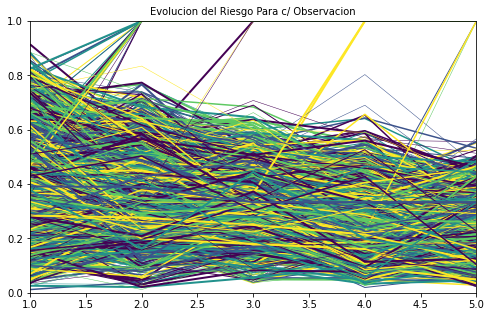

In [120]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors

#------------------------------------------------------------------------------#
print('create a df with risk index per round for every child')

risk_evolution = pd.DataFrame(df.childid.unique(),columns = ['childid'])
cols_to_keep = ['childid','score_antrp','score_salud','score_socioec','risk']

for i in dfs.keys():
    data_ronda = dfs[i].loc[:,cols_to_keep]
    data_ronda.columns = [j+'_'+str(i) if 'childid' not in j else j for j in cols_to_keep ]
    risk_evolution = pd.merge(risk_evolution,data_ronda, how = 'left', on = ['childid'])
        
print('risk_evolution shape',
      risk_evolution.shape)
#risk_evolution.head(5)
#------------------------------------------------------------------------------#
print('plot different trajectories')
np.set_printoptions(suppress=True)

risk_per_round = risk_evolution.loc[:,['risk_1','risk_2','risk_3','risk_4','risk_5']]

x = np.arange(5)+1
ys = np.array(risk_per_round)
[np.column_stack([x, y]) for y in ys]

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlim(1, 5)
#ax.xticks([1, 2, 3, 4, 5])
ax.set_ylim(0, 1)

line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               linewidths=(0.5, 1, 1.5, 2),
                               linestyles='solid')
line_segments.set_array(x)
ax.add_collection(line_segments)
#axcb = fig.colorbar(line_segments)
axcb.set_label('Line Number', fontsize=5)
ax.set_title('Evolucion del Riesgo Para c/ Observacion', fontsize=10)
plt.sci(line_segments)  
plt.show()

# Objetivo: agrupar las trayectorias

## K-Means

In [218]:
print('no need to scale X. Features are already between 0 and 1 \n','fit and predict kmeans \n')
risk = ['risk_1','risk_2','risk_3','risk_4','risk_5']
X = np.array(risk_evolution.loc[:,risk])
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score , calinski_harabasz_score


kmeans = KMeans(n_clusters=4, random_state=0, n_init = 30).fit(X)
y_kmeans = kmeans.predict(X)
import collections
print('observations per cluster',
      collections.Counter(y_kmeans),'\n')
print('Cluster centers:',
      kmeans.cluster_centers_,'\n')

print('Inertia: Sum of squared distances of samples to their closest cluster center',
      kmeans.inertia_,'\n')
print('calinski-harabaz score',
      calinski_harabasz_score(X, y_kmeans),'\n')
print('silhouette score',
      silhouette_score(X, y_kmeans),'\n')

no need to scale X. Features are already between 0 and 1 
 fit and predict kmeans 

observations per cluster Counter({0: 811, 1: 706, 2: 513, 3: 22}) 

Cluster centers: [[0.41523547 0.36633815 0.31459976 0.25759748 0.23609466]
 [0.23533184 0.22616301 0.219955   0.17855168 0.17792289]
 [0.59595164 0.50775506 0.42233417 0.36823553 0.30156224]
 [0.54290135 0.86863655 0.94082796 1.         1.        ]] 

Inertia: Sum of squared distances of samples to their closest cluster center 89.93042726123788 

calinski-harabaz score 986.8656815402069 

silhouette score 0.2335110521920301 



Text(0.5, 0.98, 'Clusterizacion de Trayectorias')

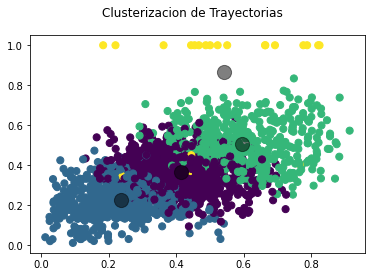

In [133]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.suptitle('Clusterizacion de Trayectorias')

## DBSCAN

In [220]:
from sklearn.cluster import DBSCAN

In [244]:
db = DBSCAN(eps=0.5, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('vemos algunas métricas para determinar la performance de nuestro modelo')
print("Estimado número de cluster: %d" % n_clusters_)
print("Estimado número de puntos ruidosos: %d" % n_noise_)
print("Coeficiente Silhouette: %0.3f" % metrics.silhouette_score(X, labels))

vemos algunas métricas para determinar la performance de nuestro modelo
Estimado número de cluster: 2
Estimado número de puntos ruidosos: 4
Coeficiente Silhouette: 0.615


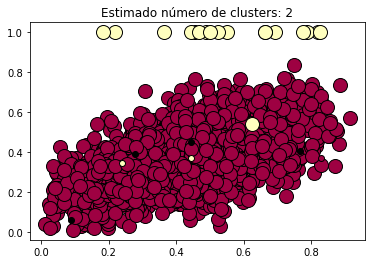

In [245]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )
plt.title("Estimado número de clusters: %d" % n_clusters_)
plt.show()